In [22]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import re

## Part 1: EDA

In [23]:
df = pd.read_csv('./glassdoor_jobs.csv')
print(df.shape)
df.head()

(1500, 12)


,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
0,Data Scientist,-1,Job Overview\nA Data Scientist at ExploreLearn...,4.2,Cambium Learning Group\n4.3,Remote,1001 to 5000 Employees,2004,Company - Private,Primary & Secondary Schools,Education,$500 million to $1 billion (USD)
1,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe\n4.4,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,Information Technology,$5 to $10 billion (USD)
2,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM\n3.9,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD)
3,Data Scientist 2,Employer Provided Salary:$94K - $183K,The Microsoft 365 team is looking for a Data S...,4.3,Microsoft\n4.3,"Redmond, WA",10000+ Employees,1975,Company - Public,Computer Hardware Development,Information Technology,$10+ billion (USD)
4,Entry Level Data Scientist 2023/2024,$48K - $78K (Glassdoor est.),"You may not realize it, but you’ve likely used...",3.9,CPChem\n3.9,"The Woodlands, TX",1001 to 5000 Employees,2000,Company - Private,Chemical Manufacturing,Manufacturing,$10+ billion (USD)


In [24]:
# Drop duplicates revealed by EDA
df = df.drop_duplicates()

# Drop rows with missing salary estimate
df = df[df['Salary Estimate'] != '-1']

# Get state from non-remote locations
df['State'] = df['Location'].apply(lambda x: 'Remote' if x == 'Remote' else (x.split(', ')[1] if ', ' in x else '-1'))

# Fix issue where company rating appears alongside company name
df['Company Name'] = df['Company Name'].str.replace(r'\n.*', '')

# Multiple listings from the same company --> non-iid
print(df['Company Name'].value_counts())

Company Name
-1                               9
Procter & Gamble\n4.1            6
TikTok\n3.5                      5
INTEL\n4.1                       5
Walmart\n3.4                     4
                                ..
Applied Engineering, Inc\n4.0    1
Mount Sinai\n3.5                 1
Webster Financial Corp\n3.5      1
Health Alliance Plan\n3.6        1
The JAAW Group                   1
Name: count, Length: 554, dtype: int64


Job Title 0.010294117647058823
Salary Estimate 0.0
Job Description 0.008823529411764706
Rating 0.06764705882352941
Company Name 0.013235294117647059
Location 0.011764705882352941
Size 0.023529411764705882
Founded 0.17941176470588235
Type of ownership 0.023529411764705882
Industry 0.09558823529411764
Sector 0.09558823529411764
Revenue 0.023529411764705882
State 0.039705882352941174


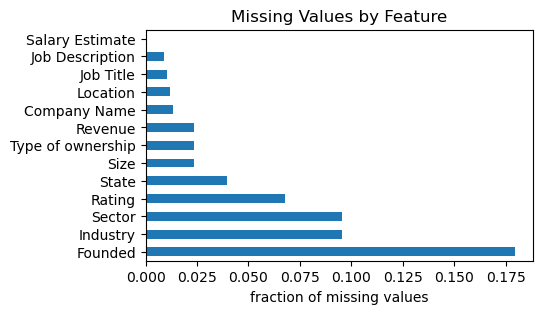

In [25]:
# Analyze missing data
missing_data = {}
for col in df.columns:
  if col in ['Rating', 'Founded']:
    num_missing = df[df[col] == -1].shape[0]
  else:
    num_missing = df[df[col] == '-1'].shape[0]
  prc_missing = num_missing / df.shape[0]
  missing_data[col] = prc_missing
  print(col, prc_missing)

plt.figure(figsize=(5,3))
series_data = pd.Series(missing_data).sort_values(ascending=False)
series_data.plot.barh()
plt.xlabel('fraction of missing values')
plt.title('Missing Values by Feature')
plt.show()

In [26]:
# Reformat 'Salary Estimate' column

def transform_salary(salary_string):
    # Assume 40hr/week for 52 weeks/year
    hours_per_year = 40 * 52

    # Case 1: annual salary range
    annual_match = re.match(r'.*\$(\d+(?:\.\d+)?)[Kk] - \$(\d+(?:\.\d+)?)[Kk].*', salary_string)
    if annual_match:
        low = float(annual_match.group(1)) * 1000
        high = float(annual_match.group(2)) * 1000
        return low, high

    # Case 2: hourly rate range
    hourly_match = re.match(r'.*\$(\d+(?:\.\d+)?) - \$(\d+(?:\.\d+)?) Per Hour.*', salary_string)
    if hourly_match:
        low_salary = float(hourly_match.group(1)) * hours_per_year
        high_salary = float(hourly_match.group(2)) * hours_per_year
        return low_salary, high_salary

    # Case 3: single annual salary value
    single_annual_match = re.match(r'.*\$(\d+(?:\.\d+)?)[Kk].*', salary_string)
    if single_annual_match:
        salary_value = float(single_annual_match.group(1).replace('K', '')) * 1000
        return salary_value, salary_value

    # Case 4: single hourly rate value
    single_hourly_match = re.match(r'.*\$(\d+(?:\.\d+)?) Per Hour.*', salary_string)
    if single_hourly_match:
        hourly_rate = float(single_hourly_match.group(1))
        low_salary = hourly_rate * hours_per_year
        high_salary = hourly_rate * hours_per_year
        return low_salary, high_salary
    
    # Print any cases we missed
    print(salary_string)
    return None, None

df['Low_Salary'], df['High_Salary'] = zip(*df['Salary Estimate'].apply(transform_salary))
df['Avg_Salary'] = (df['Low_Salary'] + df['High_Salary']) / 2
df.head(2)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,State,Low_Salary,High_Salary,Avg_Salary
1,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe\n4.4,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,Information Technology,$5 to $10 billion (USD),CA,83000.0,153000.0,118000.0
2,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM\n3.9,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD),GA,71000.0,133000.0,102000.0


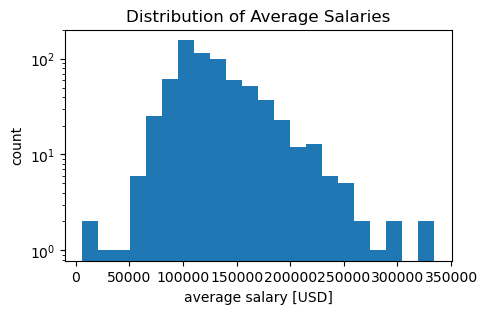

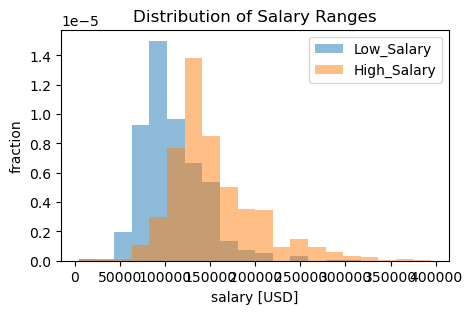

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,State,Low_Salary,High_Salary,Avg_Salary
105,Data Scientist 1,Employer Provided Salary:$5K - $7K,Requisition ID\nreq27082\n\nWorking Title\nDat...,3.8,University of New Mexico\n3.8,"Albuquerque, NM",10000+ Employees,1889,College / University,Colleges & Universities,Education,$1 to $5 billion (USD),NM,5000.0,7000.0,6000.0
123,Data Specialist,Employer Provided Salary:$30K - $35K,"Note: While this is a fully remote position, w...",4.1,Juristat,Remote,1 to 50 Employees,2012,Company - Private,Enterprise Software & Network Solutions,Information Technology,Unknown / Non-Applicable,Remote,30000.0,35000.0,32500.0
591,DATA SCIENTIST,Employer Provided Salary:$8K - $8K,DATA SCIENTIST\n\n\nReq #:\n220683\n\nDepartme...,4.2,University of Washington\n4.2,"Seattle, WA",10000+ Employees,1861,College / University,Colleges & Universities,Education,$1 to $5 billion (USD),WA,8000.0,8000.0,8000.0


In [27]:
# Visualize distribution of salaries
plt.figure(figsize=(5,3))
df['Avg_Salary'].plot.hist(bins=int(1+3.322*np.log(len(df)))) # Sturge's rule
plt.semilogy()
plt.xlabel('average salary [USD]')
plt.ylabel('count')
plt.title('Distribution of Average Salaries')
plt.show()

categories = ['Low_Salary', 'High_Salary']
bin_range = (df['Low_Salary'].min(),df['High_Salary'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[c],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('fraction')
plt.xlabel('salary [USD]')
plt.title('Distribution of Salary Ranges')
plt.show()

# Investigate outliers
df[df['High_Salary'] < 50000]

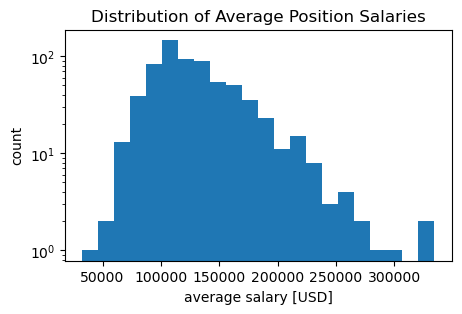

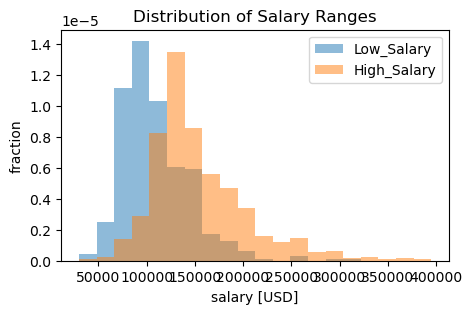

In [28]:
# The salary ranges corresponding to indices 105 and 591 are unreasonably low
# for a full-time data science position. They seem to correspond to student
# positions based on the employer name, so we will omit these from our analysis.

df.drop([105, 591], inplace=True)
df.reset_index(drop=True, inplace=True)
# Recreate histogram
plt.figure(figsize=(5,3))
df['Avg_Salary'].plot.hist(bins=int(1+3.322*np.log(len(df)))) # Sturge's rule
plt.semilogy()
plt.xlabel('average salary [USD]')
plt.ylabel('count')
plt.title('Distribution of Average Position Salaries')
plt.show()

categories = ['Low_Salary', 'High_Salary']
bin_range = (df['Low_Salary'].min(),df['High_Salary'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[c],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('fraction')
plt.xlabel('salary [USD]')
plt.title('Distribution of Salary Ranges')
plt.show()

In [29]:
# Transform 'Job Title' column

def get_job_type(title):
  if 'engineer' in title.lower():
    return 'Data Engineer'
  elif 'data scientist' in title.lower() or 'data science' in title.lower():
    return 'Data Scientist'
  elif 'analyst' in title.lower() or 'analytics' in title.lower():
    return 'Data Analyst'
  else:
    # print(title)
    return 'Other'

def get_level(title):
  if 'Entry Level' in title or 'College Graduate' in title:
    return 'Entry Level'
  elif 'Junior' in title or 'Jr. ' in title or 'Jr ' in title:
    return 'Junior'
  elif 'Senior' in title or 'Sr. ' in title or 'Sr ' in title:
    return 'Senior'
  elif 'Lead ' in title or 'Chief ' in title or 'Principal' in title:
    return 'Very Senior'
  else:
    return 'Unspecified'

df['Job Type'] = df['Job Title'].apply(get_job_type)
df['Experience Level'] = df['Job Title'].apply(get_level)
df.head(2)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,State,Low_Salary,High_Salary,Avg_Salary,Job Type,Experience Level
0,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe\n4.4,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,Information Technology,$5 to $10 billion (USD),CA,83000.0,153000.0,118000.0,Data Scientist,Unspecified
1,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM\n3.9,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD),GA,71000.0,133000.0,102000.0,Data Scientist,Entry Level


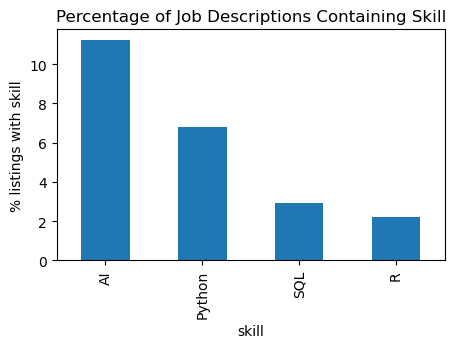

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,State,Low_Salary,High_Salary,Avg_Salary,Job Type,Experience Level,Python,R,SQL,AI
0,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe\n4.4,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,...,CA,83000.0,153000.0,118000.0,Data Scientist,Unspecified,1,1,1,0
1,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM\n3.9,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,...,GA,71000.0,133000.0,102000.0,Data Scientist,Entry Level,0,0,0,1


In [30]:
# Transform 'Job Description' column
df['Job Description'] = df['Job Description'].str.replace(r'\n', ' ')

# Create new columns using 'Job Description' column
skills_mapping = {
        "Python": ["python", "tensorflow", "pytorch", "pandas"],
        "R": ["r", "rstudio"],
        "SQL": ["sql", "postgresql", "mysql", "nosql"],
        "AI": ["ai", "artificial intelligence", "ml", "machine learning",
                                     "deep learning", "nlp", "natural language processing"],
    }

def create_skill_columns(df):
    for skill, aliases in skills_mapping.items():
        df[skill] = df['Job Description'].apply(lambda x: 1 if any(alias.lower() in x.lower().split() for alias in aliases) else 0)
    return df
df_skills = create_skill_columns(df)
percentages = df_skills[skills_mapping.keys()].mean() * 100
percentages_sorted = percentages.sort_values(ascending=False)

plt.figure(figsize=(5, 3))
percentages_sorted.plot.bar()
plt.ylabel('% listings with skill')
plt.xlabel('skill')
plt.title('Percentage of Job Descriptions Containing Skill')
plt.show()

df.head(2)

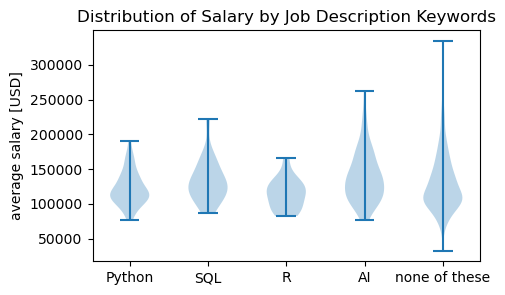

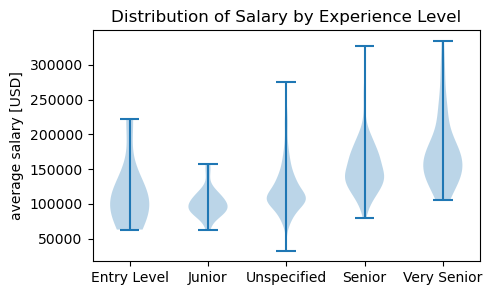

In [31]:
plt.figure(figsize=(5,3))
plt.violinplot([df[df['Python']==1]['Avg_Salary'].values,
                df[df['SQL']==1]['Avg_Salary'].values,
                df[df['R']==1]['Avg_Salary'].values,
                df[df['AI']==1]['Avg_Salary'].values,
                df[(df['Python']==0) & (df['R']==0) & (df['SQL']==0) & (df['AI']==0)]['Avg_Salary'].values])
plt.xticks([1,2,3,4,5],['Python', 'SQL', 'R', 'AI', 'none of these'])
plt.ylabel('average salary [USD]')
plt.title('Distribution of Salary by Job Description Keywords')
plt.show()

plt.figure(figsize=(5,3))
plt.violinplot([df[df['Experience Level']=='Entry Level']['Avg_Salary'].values,
                df[df['Experience Level']=='Junior']['Avg_Salary'].values,
                df[df['Experience Level']=='Unspecified']['Avg_Salary'].values,
                df[df['Experience Level']=='Senior']['Avg_Salary'].values,
                df[df['Experience Level']=='Very Senior']['Avg_Salary'].values
            ])
plt.xticks([1,2,3,4,5],['Entry Level','Junior','Unspecified','Senior','Very Senior'])
plt.ylabel('average salary [USD]')
plt.title('Distribution of Salary by Experience Level')
plt.show()

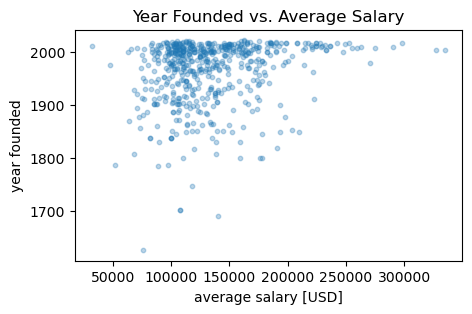

            Avg_Salary  Founded
Avg_Salary     1.00000  0.16503
Founded        0.16503  1.00000


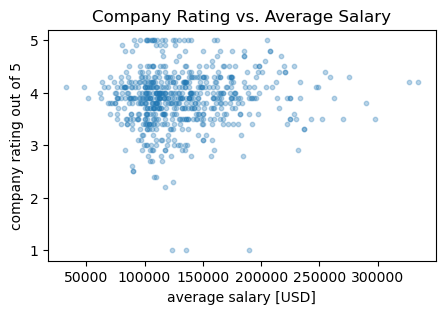

            Avg_Salary    Rating
Avg_Salary    1.000000  0.070715
Rating        0.070715  1.000000


In [32]:
# Compare continuous features to target

# plt.figure(figsize=(5,3))
df[df['Founded'] != -1].plot.scatter('Avg_Salary','Founded',figsize=(5,3),alpha=0.3,s=10)
plt.xlabel('average salary [USD]')
plt.ylabel('year founded')
plt.title('Year Founded vs. Average Salary')
plt.show()
print(df[['Avg_Salary', 'Founded']].corr())

# plt.figure(figsize=(5,3))
df[df['Rating'] != -1].plot.scatter('Avg_Salary','Rating',figsize=(5,3),alpha=0.3,s=10)
plt.xlabel('average salary [USD]')
plt.ylabel('company rating out of 5')
plt.title('Company Rating vs. Average Salary')
plt.show()
print(df[['Avg_Salary', 'Rating']].corr())

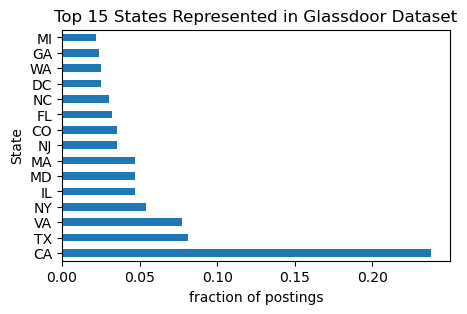

In [33]:
plt.figure(figsize=(5,3))
pd.value_counts(df[(df['State'] != '-1') & (df['State'] != 'Remote')]['State'],normalize=True).nlargest(15).plot.barh()
plt.xlabel('fraction of postings')
plt.title('Top 15 States Represented in Glassdoor Dataset')
plt.show()

In [34]:
# Group "Unknown" and missing values together in the same category

df['Size'] = df['Size'].replace('Unknown', '-1')
df['Type of ownership'] = df['Type of ownership'].replace('Unknown', '-1')
df['Revenue'] = df['Revenue'].replace('Unknown / Non-Applicable', '-1')

ftrs = ['Size', 'Type of ownership', 'Revenue']
for ftr in ftrs:
  print(df[ftr].value_counts())
  print('')

Size
10000+ Employees           237
1001 to 5000 Employees     118
1 to 50 Employees           71
51 to 200 Employees         68
-1                          55
201 to 500 Employees        44
5001 to 10000 Employees     43
501 to 1000 Employees       42
Name: count, dtype: int64

Type of ownership
Company - Private                 275
Company - Public                  263
Nonprofit Organization             37
Subsidiary or Business Segment     26
Government                         21
-1                                 18
College / University               16
Hospital                            8
Self-employed                       6
Private Practice / Firm             4
Contract                            4
Name: count, dtype: int64

Revenue
-1                                  259
$10+ billion (USD)                  153
$1 to $5 billion (USD)               69
$100 to $500 million (USD)           51
$5 to $25 million (USD)              35
$5 to $10 billion (USD)              33
$25 to $1

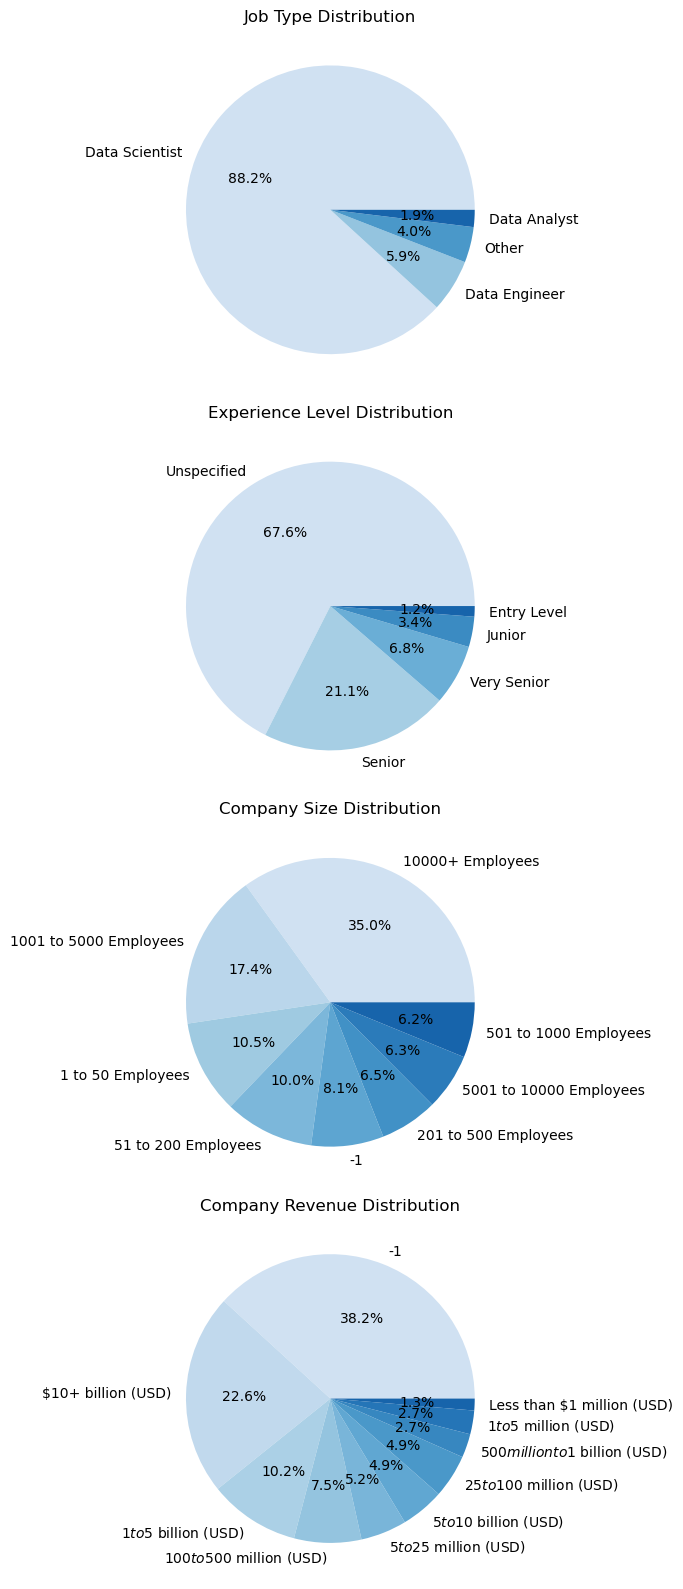

In [35]:
import matplotlib.pyplot as plt
from matplotlib.cm import Blues

# Set a common figsize for all plots
fig, axs = plt.subplots(4, 1, figsize=(16, 16))

# Job Type Distribution
value_counts = df['Job Type'].value_counts()
axs[0].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=Blues(np.linspace(0.2, 0.8, len(value_counts))))
axs[0].set_title('Job Type Distribution')

# Experience Level Distribution
value_counts = df['Experience Level'].value_counts()
axs[1].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=Blues(np.linspace(0.2, 0.8, len(value_counts))))
axs[1].set_title('Experience Level Distribution')

# Company Size Distribution
value_counts = df['Size'].value_counts()
axs[2].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=Blues(np.linspace(0.2, 0.8, len(value_counts))))
axs[2].set_title('Company Size Distribution')

# Company Revenue Distribution
value_counts = df['Revenue'].value_counts()
axs[3].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=Blues(np.linspace(0.2, 0.8, len(value_counts))))
axs[3].set_title('Company Revenue Distribution')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Part 2: Preprocessing

In [36]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split

# -1 represents missing values
df.replace(-1, np.nan, inplace=True)

# drop columns that are not useful for our analysis
to_exclude = ['Job Title', 'Job Description', 'Salary Estimate', 'Low_Salary', 'High_Salary']
df.drop(columns=to_exclude, inplace=True)

# the target variable
y = df['Avg_Salary']
df.drop(columns=['Avg_Salary'],inplace=True)
# the unprocessed feature matrix
X = df.values
print(X.shape)
# the feature names
ftrs = df.columns

# let's split to train, CV, and test
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_CV.shape)
print(X_test.shape)

(678, 16)
(406, 16)
(136, 16)
(136, 16)


In [37]:
# # -1 represents missing values
# df.replace(-1, np.nan, inplace=True)

# # drop columns that are not useful for our analysis
# to_exclude = ['Job Title', 'Job Description', 'Salary Estimate', 'Low_Salary', 'High_Salary']
# df.drop(columns=to_exclude, inplace=True)

# # the target variable
# y = df['Avg_Salary']
# df.drop(columns=['Avg_Salary'],inplace=True)
# # the unprocessed feature matrix
# X = df.values
# print(X.shape)
# # the feature names
# ftrs = df.columns


In [38]:
# collect the various features
cat_ftrs = ['Company Name', 'Location', 'State', 'Type of ownership', 'Industry', 'Job Type']
ordinal_ftrs = ['Size', 'Revenue', 'Experience Level']
ordinal_cats = [['-1', '1 to 50 Employees', '51 to 200 Employees', '201 to 500 Employees',
                '501 to 1000 Employees', '1001 to 5000 Employees', '5001 to 10000 Employees',
                '10000+ Employees'],
                ['-1', 'Less than $1 million (USD)', '$1 to $5 million (USD)', '$5 to $25 million (USD)',
                '$25 to $100 million (USD)', '$100 to $500 million (USD)',
                '$500 million to $1 billion (USD)', '$1 to $5 billion (USD)',
                '$5 to $10 billion (USD)', '$10+ billion (USD)'],
                ['Entry Level', 'Junior', 'Unspecified', 'Senior', 'Very Senior']]
num_ftrs = ['Rating', 'Founded', 'Python', 'R', 'SQL', 'AI']

In [39]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [40]:
# from sklearn.model_selection import GroupShuffleSplit
# random_state = 42
# # separate the feature matrix X, and target variable y
# y = df['Avg_Salary']
# X = df.loc[:, df.columns != 'Avg_Salary']

# groups = df['Company Name']
# gss = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=random_state)

# for train_idx, other_idx in gss.split(X, y, groups):
#     X_train = np.array(X)[train_idx]
#     y_train = np.array(y)[train_idx]
#     X_other = np.array(X)[other_idx]
#     y_other = np.array(y)[other_idx]
#     second_split_groups = np.array(np.array(groups)[other_idx])
#     gss = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)
#     for val_idx, test_idx in gss.split(X_other, y_other, second_split_groups):
#         X_val, y_val = np.array(X)[val_idx], np.array(y)[val_idx]
#         X_test, y_test = np.array(X)[test_idx], np.array(y)[test_idx]
#     X_train = pd.DataFrame(X_train, columns=X.columns)
#     X_val = pd.DataFrame(X_val, columns=X.columns)
#     X_test = pd.DataFrame(X_test, columns=X.columns)

#     # normalize labels
#     # label_scaler = StandardScaler()
#     # y_train_scaled = label_scaler.fit_transform(np.array(y_train).reshape(-1,1))
#     # y_val_scaled = label_scaler.transform(np.array(y_val).reshape(-1,1))
#     # y_test_scaled = label_scaler.transform(np.array(y_test).reshape(-1,1))
#     # y_train = y_train_scaled.flatten()
#     # y_val = y_val_scaled.flatten()
#     # y_test = y_test_scaled.flatten()

#     clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
#                                                         # later on we will add other steps here

#     X_train_prep = clf.fit_transform(X_train)
#     X_val_prep = clf.transform(X_val)
#     X_test_prep = clf.transform(X_test)

#     # Get shapes
#     print(X_train_prep.shape)
#     print(X_val_prep.shape)
#     print(X_test_prep.shape)
#     print('')

#     X_train = pd.DataFrame(X_train_prep)
#     X_CV = pd.DataFrame(X_val_prep)
#     X_test = pd.DataFrame(X_test_prep)
#     y_CV = y_val

In [41]:
# from sklearn.model_selection import GroupShuffleSplit

# random_state=42

# # y = df['Avg_Salary']
# # X = df.loc[:, df.columns != 'Avg_Salary']

# groups = df['Company Name']
# gss = GroupShuffleSplit(n_splits=5, train_size=0.6, random_state=random_state)

# for train_idx, other_idx in gss.split(X, y, groups):
#     X_train = np.array(X)[train_idx]
#     y_train = np.array(y)[train_idx]
#     X_other = np.array(X)[other_idx]
#     y_other = np.array(y)[other_idx]
#     second_split_groups = np.array(np.array(groups)[other_idx])
#     gss = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)
#     for val_idx, test_idx in gss.split(X_other, y_other, second_split_groups):
#         X_val, y_val = np.array(X)[val_idx], np.array(y)[val_idx]
#         X_test, y_test = np.array(X)[test_idx], np.array(y)[test_idx]
#     X_train = pd.DataFrame(X_train, columns=X.columns)
#     X_val = pd.DataFrame(X_val, columns=X.columns)
#     X_test = pd.DataFrame(X_test, columns=X.columns)

In [42]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split

random_state=42

# # let's split to train, CV, and test
# groups = df['Company Name']
# gss = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=random_state)
# # X_train, X_other, y_train, y_other = next(gss.split(X, y, groups=groups))
# # second_split_groups = groups[X_other]
# # gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)
# # X_CV, X_test, y_CV, y_test = next(gss2.split(X_other, y_other, groups=second_split_groups))


# for train_idx, other_idx in gss.split(df, y, groups):
#     X_train = np.array(X)[train_idx]
#     y_train = np.array(y)[train_idx]
#     X_other = np.array(X)[other_idx]
#     y_other = np.array(y)[other_idx]
#     train_groups = np.array(groups)[train_idx]
#     second_split_groups = np.array(np.array(groups)[other_idx])
#     gss = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)
#     for val_idx, test_idx in gss.split(X_other, y_other, second_split_groups):
#         X_val, y_val = np.array(X)[val_idx], np.array(y)[val_idx]
#         X_test, y_test = np.array(X)[test_idx], np.array(y)[test_idx]
#         val_groups = np.array(second_split_groups)[val_idx]
#         test_groups = np.array(second_split_groups)[test_idx]
#     X_train = pd.DataFrame(X_train, columns=X.columns)
#     X_val = pd.DataFrame(X_val, columns=X.columns)
#     X_test = pd.DataFrame(X_test, columns=X.columns)
# gss2 = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)


# X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.4, random_state=42)

# print(X_train.shape)
# print(X_CV.shape)
# print(X_test.shape)

# Splitting

In [43]:
# # let's split to train, CV, and test
# X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
# X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

# print(X_train.shape)
# print(X_CV.shape)
# print(X_test.shape)

In [72]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
final_scaler = StandardScaler()
X_prep = final_scaler.fit_transform(X_prep)
# collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = final_scaler.transform(df_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(df_CV.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = final_scaler.transform(df_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)

print('data dimensions:',df_train.shape)
perc_missing_per_ftr = df_train.isnull().sum(axis=0)/df_train.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
frac_missing = sum(df_train.isnull().sum(axis=1)!=0)/df_train.shape[0]
print('fraction of points with missing values:',frac_missing)

(406, 654)
(136, 654)
(136, 654)
data dimensions: (406, 654)
fraction of missing values in features:
num__Rating     0.056650
num__Founded    0.165025
dtype: float64
fraction of points with missing values: 0.16748768472906403


### Multivariate Imputation

In [45]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators=1), random_state=42)
# imputer = IterativeImputer(estimator = LinearRegression(), random_state=42)
X_impute = imputer.fit_transform(df_train)
df_train_imp = pd.DataFrame(data=X_impute, columns = df_train.columns)

df_CV_imp = pd.DataFrame(data=imputer.transform(df_CV), columns = df_train.columns)
df_test_imp = pd.DataFrame(data=imputer.transform(df_test), columns = df_train.columns)

### XGBoost

In [46]:
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
            #   "reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
            #   "reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              "missing": [np.nan], 
            #   "max_depth": [1,3,10,30,100],
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

XGB = xgboost.XGBRegressor()
XGB.set_params(**ParameterGrid(param_grid)[0]) # ONLY THE ONE MODEL IS TRAINED HERE!
XGB.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_CV, y_CV)], verbose=False)
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

the CV RMSE: 34029.12846034045
the test RMSE: 28004.124905672983
the test R2: 0.3840426092556902


### Reduced-features model

In [47]:
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
   
def xgb_model(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):

    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    Y_train = np.reshape(np.array(Y_train), (1, -1)).ravel()
    y_CV = np.reshape(np.array(y_CV), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    XGB = xgboost.XGBRegressor(n_jobs=1)
    
    # find the best parameter set
    param_grid = {"learning_rate": [0.03],
                  "n_estimators": [10000],
                  "seed": [0],
                  #"reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "missing": [np.nan], 
                  #"max_depth": [1,3,10,30,100,],
                  "colsample_bytree": [0.9],              
                  "subsample": [0.66]}

    pg = ParameterGrid(param_grid)

    scores = np.zeros(len(pg))

    for i in range(len(pg)):
        if verbose >= 5:
            print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        XGB.set_params(**params)
        eval_set = [(X_CV, y_CV)]
        XGB.fit(X_train, Y_train,
                early_stopping_rounds=50, eval_set=eval_set, verbose=False)# with early stopping
        y_CV_pred = XGB.predict(X_CV, ntree_limit=XGB.best_ntree_limit)
        scores[i] = mean_squared_error(y_CV,y_CV_pred)

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with best parameter set
    XGB.set_params(**best_params[0])
    XGB.fit(X_train,Y_train,
            early_stopping_rounds=50,eval_set=eval_set, verbose=False)
    y_test_pred = XGB.predict(X_test, ntree_limit=XGB.best_ntree_limit)

    if verbose >= 1:
        print ('The MSE is:',mean_squared_error(y_test,y_test_pred))
    if verbose >= 2:
        print ('The predictions are:')
        print (y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(XGB.feature_importances_)

    return (mean_squared_error(y_test,y_test_pred), y_test_pred, XGB.feature_importances_)

# Function: Reduced-feature XGB model
# all the inputs need to be pandas DataFrame
def reduced_feature_xgb(X_train, Y_train, X_CV, y_CV, X_test, y_test):
    
    # find all unique patterns of missing value in test set
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()
    
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern

                sub_X_test = pd.concat([sub_X_test,X_test.iloc[[j]]])# append the according X_test row j to the subset
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])# append the according y_test row j

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()   
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]
        
        # run XGB
        sub_y_test_pred = xgb_model(sub_X_train, sub_Y_train, sub_X_CV, 
                                       sub_y_CV, sub_X_test, sub_y_test, verbose=0)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        print('   RMSE:',np.sqrt(mean_squared_error(sub_y_test,sub_y_test_pred)))
        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
               
    # get global RMSE
    total_RMSE = np.sqrt(mean_squared_error(y_test,all_y_test_pred))
    total_R2 =  r2_score(y_test,all_y_test_pred)
    return total_RMSE, total_R2

In [48]:
mask = df_test[df_test.columns].isnull()

unique_rows, counts = np.unique(mask, axis=0,return_counts=True)
print(unique_rows.shape) # 3 patterns, we will train 3 models
for i in range(len(counts)):
    print(counts[i])

(3, 654)
111
17
8


In [49]:
RMSE, R2 = reduced_feature_xgb(df_train, y_train, df_CV, y_CV, df_test, y_test)
print('final RMSE:', RMSE)
print('final R2:', R2)

there are 3 unique missing value patterns.
working on unique pattern 0


   RMSE: 28902.34196864096
working on unique pattern 1
   RMSE: 19769.006575622163
working on unique pattern 2
   RMSE: 35239.65387815087
final RMSE: 28349.42594755658
final R2: 0.36875900325057975


# FRESH

In [111]:
mask = df[df.columns].isnull()

unique_rows, counts = np.unique(mask, axis=0,return_counts=True)
print(unique_rows.shape) # 6 patterns, we will train 6 models
for i in range(len(counts)):
    # print True feature names
    for j in range(len(unique_rows[i])):
        if unique_rows[i][j] == True:
            print(ftrs[j])
    print(unique_rows[i],counts[i])

(4, 16)
[False False False False False False False False False False False False
 False False False False] 555
Founded
[False False False False  True False False False False False False False
 False False False False] 77
Rating
[ True False False False False False False False False False False False
 False False False False] 1
Rating
Founded
[ True False False False  True False False False False False False False
 False False False False] 45


In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupShuffleSplit
# import elastic net
from sklearn.linear_model import ElasticNet

def best_model(X_train, y_train, X_CV, y_CV, X_test, y_test, ML_algo, param_grid, verbose=1):

    k_fold = KFold(n_splits=4, shuffle=True, random_state=42)

    # gss = GroupShuffleSplit(n_splits=4, train_size=0.75, random_state=42)
    #gss.split(X_train, y_train, groups=X_train['']
        
    grid = GridSearchCV(ML_algo, param_grid=param_grid, cv=k_fold, scoring='neg_root_mean_squared_error')
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # best_models.append(grid.best_estimator_)
    test_score = -grid.score(X_test, y_test)
    # test_scores.append(-test_score)
    y_test_pred = grid.predict(X_test)

    ## FEATURE IMPORTANCE CODE ##
    if isinstance(ML_algo, ElasticNet):
        feature_names = X_train.columns
        print('test score:',grid.score(X_test,y_test))
        # coefs = grid.best_estimator_[-1].coef_[0]
        coefs = grid.best_estimator_.coef_
        sorted_indcs = np.argsort(np.abs(coefs))
        
        plt.figure(figsize=(10,6))
        plt.rcParams.update({'font.size': 11})
        plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
        plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
        plt.xlabel('coefficient')
        plt.title('all scaled')
        plt.tight_layout()
        # plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
        plt.show()

    if isinstance(ML_algo, svm.SVR):
        feature_names = X_train.columns
        print('test score:',grid.score(X_test,y_test))
        coefs = grid.best_estimator_.coef_[0]
        sorted_indcs = np.argsort(np.abs(coefs))
        
        plt.figure(figsize=(10,6))
        plt.rcParams.update({'font.size': 11})
        plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
        plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
        plt.xlabel('coefficient')
        plt.title('all scaled')
        plt.tight_layout()
        # plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
        plt.show()

    if isinstance(ML_algo, xgboost.XGBRegressor):
        feature_names = X_train.columns
        print('test score:',grid.score(X_test,y_test))
        coefs = grid.best_estimator_.feature_importances_
        sorted_indcs = np.argsort(np.abs(coefs))
        
        plt.figure(figsize=(10,6))
        plt.rcParams.update({'font.size': 11})
        plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
        plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
        plt.xlabel('coefficient')
        plt.title('all scaled')
        plt.tight_layout()
        # plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
        plt.show()
    
    if isinstance(ML_algo, RandomForestRegressor):
        feature_names = X_train.columns
        print('test score:',grid.score(X_test,y_test))
        coefs = grid.best_estimator_.feature_importances_
        sorted_indcs = np.argsort(np.abs(coefs))
        
        plt.figure(figsize=(10,6))
        plt.rcParams.update({'font.size': 11})
        plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
        plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
        plt.xlabel('coefficient')
        plt.title('all scaled')
        plt.tight_layout()
        # plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
        plt.show()

    return (test_score, y_test_pred, grid.best_estimator_)

# Create a generic reduced_feature function
# all the inputs need to be pandas DataFrame
def reduced_feature(X_train, Y_train, X_CV, y_CV, X_test, y_test, ML_algo, param_grid):
    
    # find all unique patterns of missing value in test set
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()

    best_mods = []
    
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern

                sub_X_test = pd.concat([sub_X_test,X_test.iloc[[j]]])# append the according X_test row j to the subset
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])# append the according y_test row j

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()   
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]
        
        # run ML algorithm
        sub_y_test_pred = best_model(sub_X_train, sub_Y_train, sub_X_CV, 
                                       sub_y_CV, sub_X_test, sub_y_test, ML_algo, param_grid, verbose=0)
        best_mod = sub_y_test_pred[2]
        best_mods.append(best_mod)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        print('   RMSE:',np.sqrt(mean_squared_error(sub_y_test,sub_y_test_pred)))
        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])

        # ## FEATURE IMPORTANCE CODE ##
        # test_score = best_mod.score(sub_X_test,sub_y_test)
        # # ftr_names = df_train.columns
        # ftr_names = sub_X_train.columns

        # nr_runs = 10
        # scores = np.zeros([len(ftr_names),nr_runs])

        # for i in range(len(ftr_names)):
        #     # print('shuffling '+str(ftr_names[i]))
        #     acc_scores = []
        #     for j in range(nr_runs):
        #         X_test_shuffled = sub_X_test.copy()
        #         X_test_shuffled[ftr_names[i]] = np.random.permutation(sub_X_test[ftr_names[i]].values)
        #         acc_scores.append(best_mod.score(X_test_shuffled,sub_y_test))
        #     # print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
        #     scores[i] = acc_scores
        #     # sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
        #     sorted_indcs = np.argsort(np.mean(scores,axis=1))[-10:][::-1]

        # plt.rcParams.update({'font.size': 11})
        # plt.figure(figsize=(5,3))
        # plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
        # plt.axvline(test_score,label='test score')
        # plt.title("Permutation Importances (test set)")
        # plt.xlabel('score with perturbed feature')
        # plt.legend()
        # plt.tight_layout()
        # plt.show()
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
               
    # get global RMSE
    total_RMSE = np.sqrt(mean_squared_error(y_test,all_y_test_pred))
    total_R2 =  r2_score(y_test,all_y_test_pred)
    return total_RMSE, total_R2, best_mods

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_params = {'max_depth': [1, 3, 10, 30, None],
             'max_features': [0.25, 0.5, 0.75, 1.0]}

svr_model = SVR(kernel='linear')
svr_params = {'gamma': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
              'C': [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]}

knn_model = KNeighborsRegressor()
knn_params = {"n_neighbors": range(1, 21),
              "weights": ['uniform', 'distance']}

elastic_model = ElasticNet()
elastic_params = {'alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
                  'l1_ratio': np.linspace(0, 1, 5)}

linreg_model = LinearRegression()
linreg_params = {}

In [52]:
df_train.head()

,num__Rating,num__Founded,num__Python,num__R,num__SQL,num__AI,cat__Company Name_-1,cat__Company Name_ABBVIE\n3.9,cat__Company Name_ABS Consulting\n3.7,cat__Company Name_ADM Associates\n3.7,...,cat__Industry_Vehicle Dealers,cat__Industry_Video Game Publishing,cat__Industry_Wholesale,cat__Job Type_Data Analyst,cat__Job Type_Data Engineer,cat__Job Type_Data Scientist,cat__Job Type_Other,ord__Size,ord__Revenue,ord__Experience Level
0,-1.497822,0.844368,-0.266908,-0.174519,5.992419,-0.344176,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,4.0,3.0
1,0.611244,-1.150228,-0.266908,-0.174519,-0.166878,-0.344176,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,9.0,2.0
2,0.036044,-0.989374,-0.266908,-0.174519,-0.166878,-0.344176,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,8.0,1.0
3,-0.539156,0.217035,-0.266908,-0.174519,-0.166878,-0.344176,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,9.0,2.0
4,0.994710,0.747855,-0.266908,-0.174519,-0.166878,-0.344176,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0


# Elastic Net

there are 3 unique missing value patterns.
working on unique pattern 0
{'alpha': 100.0, 'l1_ratio': 1.0}
test score: -31179.429270398192


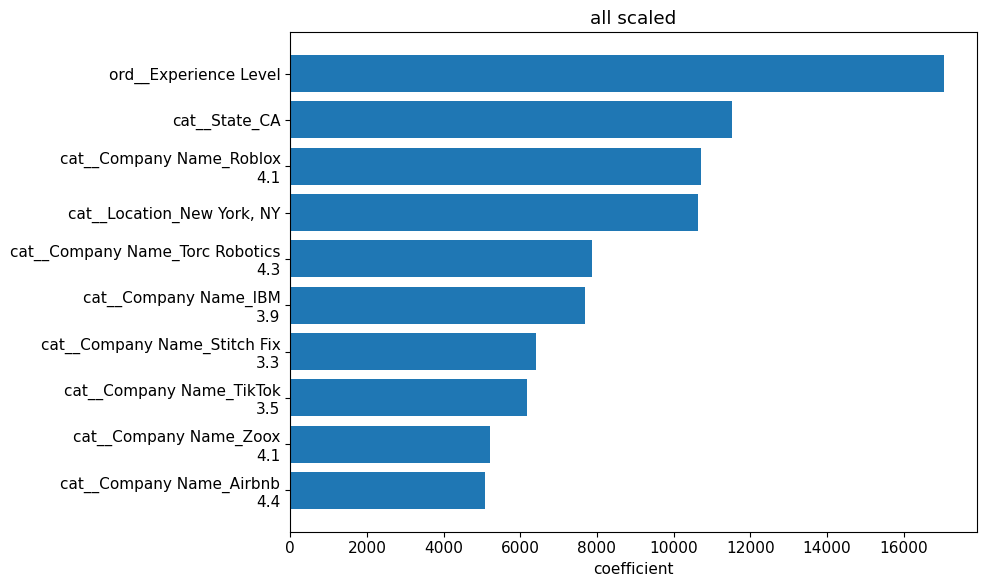

   RMSE: 31179.429270398192
working on unique pattern 1
{'alpha': 1000.0, 'l1_ratio': 1.0}
test score: -19511.966912937154


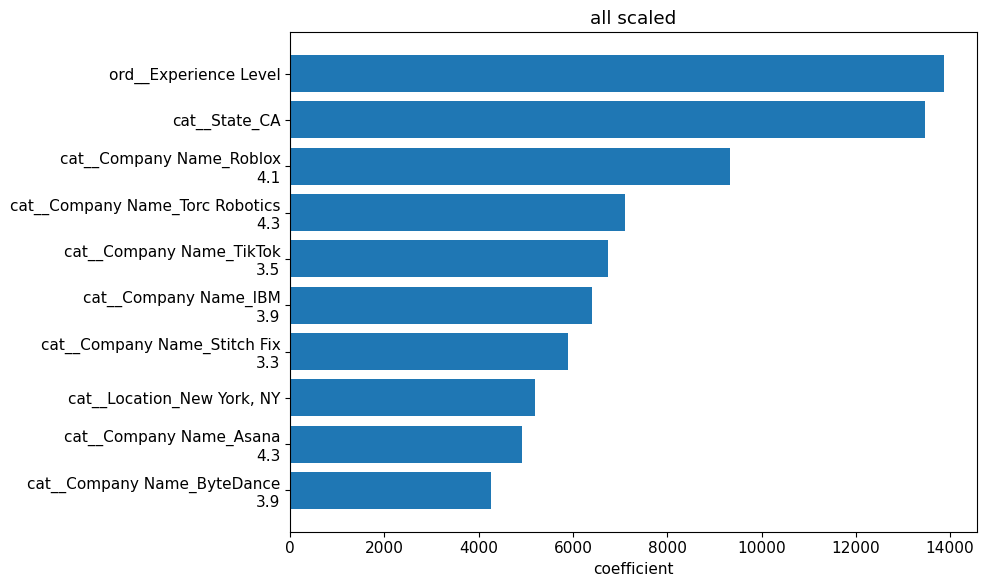

   RMSE: 19511.966912937154
working on unique pattern 2
{'alpha': 1000.0, 'l1_ratio': 1.0}
test score: -33723.04682043897


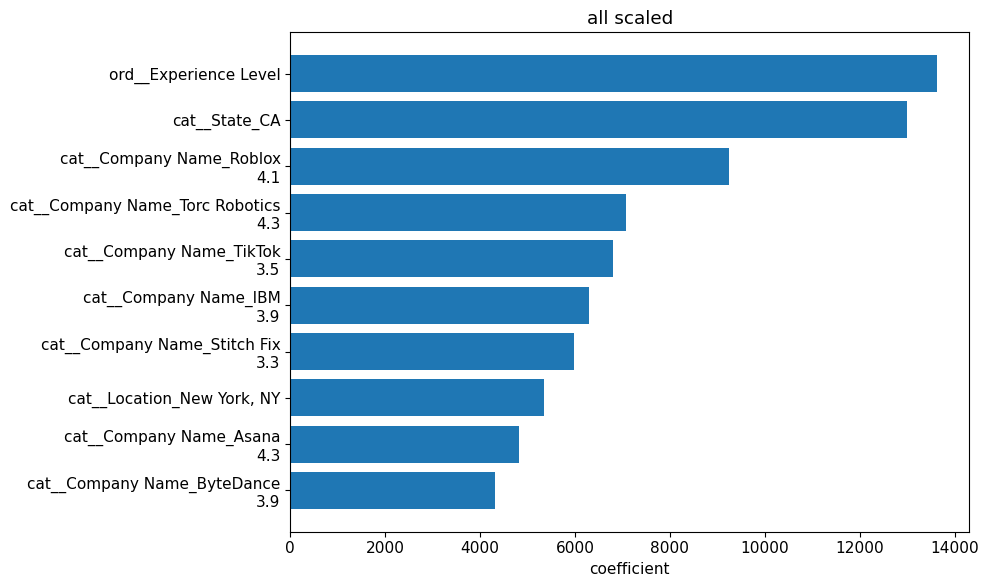

   RMSE: 33723.04682043897
final RMSE: 30132.00656392516
final R2: 0.2868797561780396


In [89]:
RMSE, R2, best_elastic = reduced_feature(df_train, y_train, df_CV, y_CV, df_test, y_test, elastic_model, elastic_params)
print('final RMSE:', RMSE)
print('final R2:', R2)

# KNN Regressor

In [87]:
RMSE, R2, best_knn = reduced_feature(df_train, y_train, df_CV, y_CV, df_test, y_test, knn_model, knn_params)
print('final RMSE:', RMSE)
print('final R2:', R2)

there are 3 unique missing value patterns.
working on unique pattern 0
{'n_neighbors': 5, 'weights': 'distance'}
   RMSE: 55877.66313548518
working on unique pattern 1
{'n_neighbors': 4, 'weights': 'distance'}
   RMSE: 71114.17926533999
working on unique pattern 2
{'n_neighbors': 5, 'weights': 'distance'}
   RMSE: 41922.23210583188
final RMSE: 57305.25897822643
final R2: -1.579262937523081


# Vanilla Linear Regression

In [ ]:
RMSE, R2, best_vanilla = reduced_feature(df_train, y_train, df_CV, y_CV, df_test, y_test, linreg_model, linreg_params)
print('final RMSE:', RMSE)
print('final R2:', R2)

there are 3 unique missing value patterns.
working on unique pattern 0
{}
   RMSE: 872270826931151.0
working on unique pattern 1
{}
   RMSE: 1215075136897419.2
working on unique pattern 2
{}
   RMSE: 4896565189705007.0
final RMSE: 1488595849824581.2
final R2: -1.74044484994244e+21


# Random Forest

there are 3 unique missing value patterns.
working on unique pattern 0
{'max_depth': 30, 'max_features': 0.25}
test score: -27042.936471053956


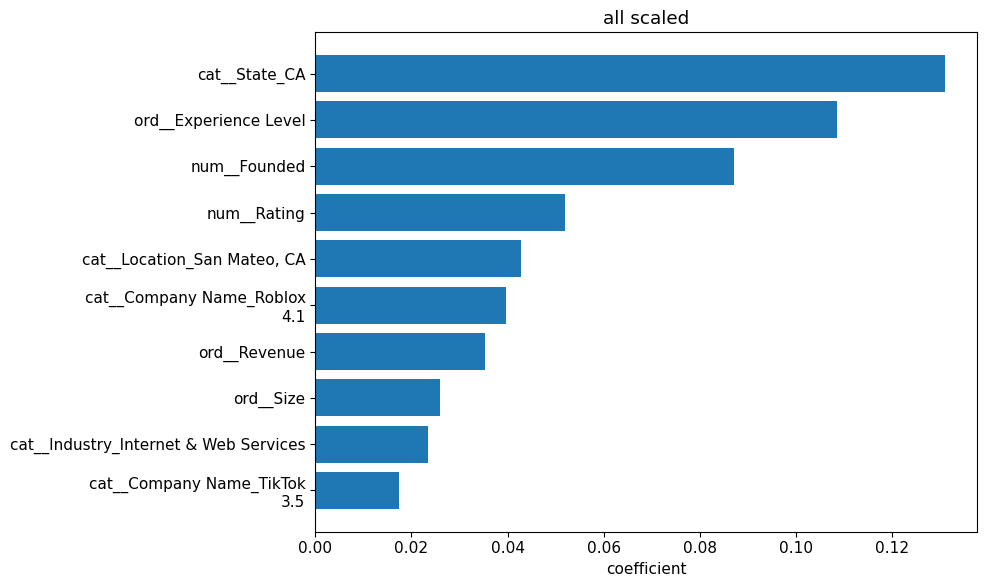

   RMSE: 27042.936471053956
working on unique pattern 1
{'max_depth': 30, 'max_features': 0.5}
test score: -23619.063537004447


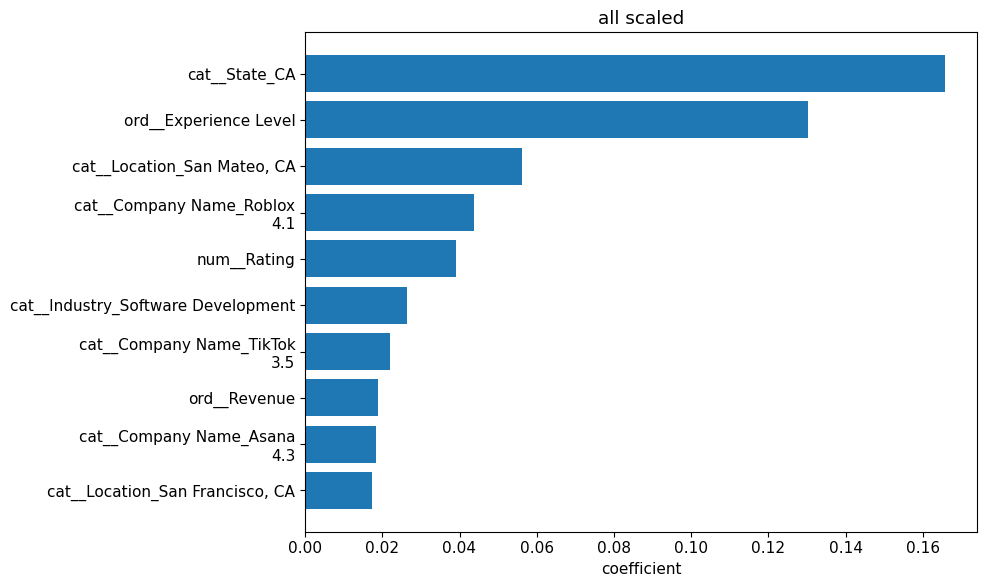

   RMSE: 23619.063537004447
working on unique pattern 2
{'max_depth': None, 'max_features': 0.25}
test score: -34826.994366654726


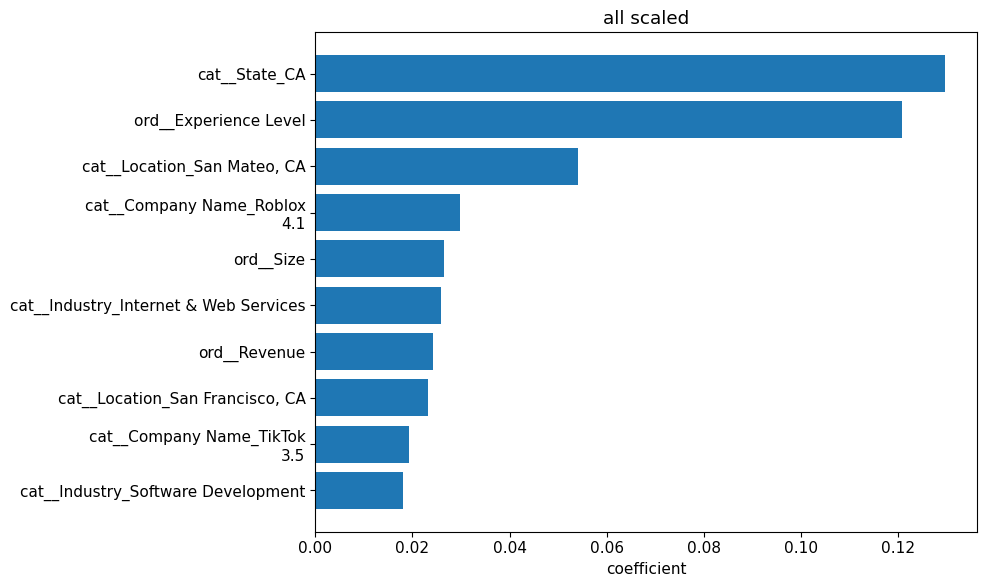

   RMSE: 34826.994366654726
final RMSE: 27165.55248591278
final R2: 0.42037949283635756


In [98]:
RMSE, R2, best_rf = reduced_feature(df_train, y_train, df_CV, y_CV, df_test, y_test, rf_model, rf_params)
print('final RMSE:', RMSE)
print('final R2:', R2)

# Support Vector Machine

there are 3 unique missing value patterns.
working on unique pattern 0
{'C': 1000.0, 'gamma': 0.001}
test score: -35833.47585188466
[ 1.79464595e+03  1.61179084e+03 -1.72718627e+03 -5.06682909e+02
 -3.64122319e+02  3.56027111e+02 -9.82609946e+02 -4.49619576e+02
 -4.11569922e+02 -4.06580596e+02  5.32907052e-14  1.11492353e+03
 -3.23576787e+03 -1.16858888e+03  2.67420260e+03 -3.45447278e+02
 -8.67170945e+02  1.30245979e+03  6.39488462e-14  6.02385138e+02
  3.21393106e+01  3.40592893e+03 -1.23415626e+02 -8.74477698e+02
  1.63424829e-13  1.57665090e+02 -9.99303775e+02 -2.80788077e+02
 -1.13712774e+03 -4.11086624e+02  2.73720859e+02 -1.01233818e+03
 -3.55271368e-14 -9.61847516e+02 -5.24010346e+02 -2.07724353e+02
  3.90320680e+03 -1.39868410e+03 -1.40927469e+03  0.00000000e+00
 -7.74471499e+02 -4.32853268e+02 -8.16436299e+02  3.13154471e+02
 -7.79498015e+02 -5.95180705e+02 -3.02586141e+02  1.00277062e+02
 -2.69833944e+02 -1.04888442e+03  6.94923015e+02 -5.78187355e+02
 -9.72248899e+01  1.847

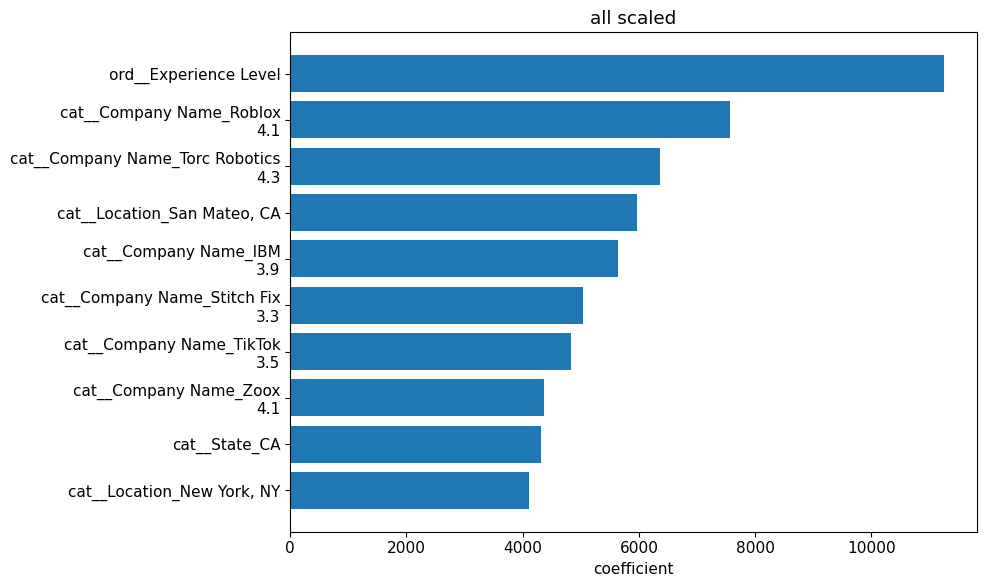

   RMSE: 35833.47585188466
working on unique pattern 1
{'C': 1000.0, 'gamma': 0.001}
test score: -24676.274253982247
[ 1.77703539e+03 -1.94136669e+03 -1.14067746e+03 -1.12597787e+02
  3.15720551e+02 -1.06386600e+03 -3.74945669e+02 -3.67958080e+02
 -3.40372841e+02 -6.87087243e+02  1.31199975e+03 -3.16026714e+03
 -1.03072419e+03  2.59383053e+03 -4.23734497e+02 -6.93251837e+02
  1.27050922e+03 -9.46248712e+02  6.62071618e+02  1.57840784e+02
  3.56092060e+03 -1.15715574e+02 -7.81200032e+02 -5.11668764e+02
  1.51735362e+02 -7.22762885e+02 -2.24367615e+02 -1.20391584e+03
 -3.60244765e+02  3.78831032e+02 -8.35195101e+02 -1.69642085e+03
 -7.96829441e+02 -5.23055939e+02 -2.83489124e+01  4.05877407e+03
 -1.49453093e+03 -1.24104472e+03  4.26325641e-14 -7.78368146e+02
 -3.61088677e+02 -6.87059544e+02  3.72844654e+02 -6.43694722e+02
 -6.23533281e+02 -2.56381489e+02  2.13666701e+02 -2.58656523e+02
 -1.27262682e+03  9.86550266e+02 -6.66745534e+02 -1.70677584e+02
 -1.99961280e+03 -5.34729464e+02  8.79

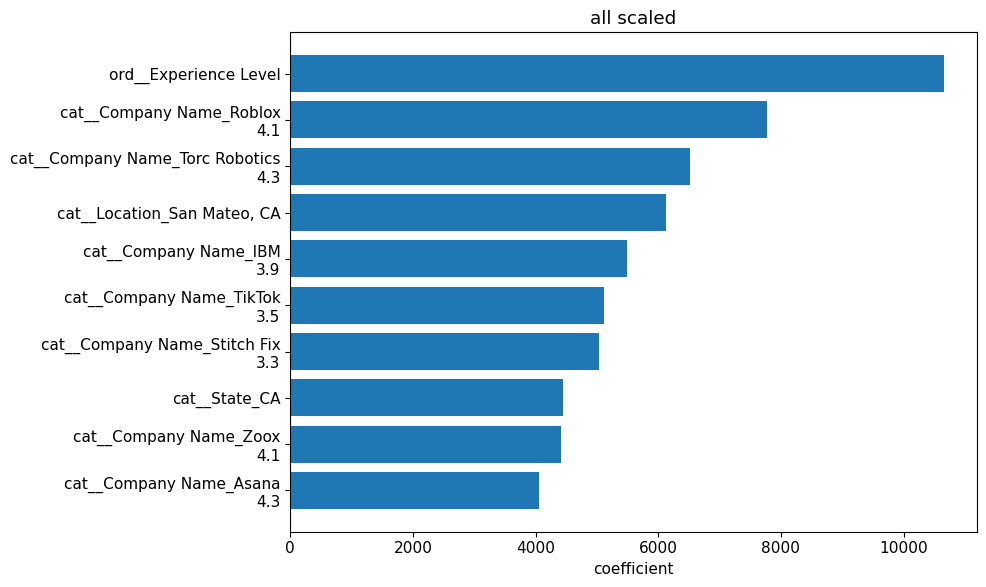

   RMSE: 24676.274253982247
working on unique pattern 2
{'C': 1000.0, 'gamma': 0.001}
test score: -30968.22900232715
[-1.88631706e+03 -9.22535405e+02 -7.33282389e+01  6.05369576e+02
 -7.25460332e+02 -3.45767063e+02 -3.82108580e+02 -3.78339670e+02
 -8.85786651e+02  1.03037406e+03 -3.10519182e+03 -1.10502793e+03
  2.61483332e+03 -4.02682152e+02 -7.54026954e+02  1.13255832e+03
 -6.66733640e+02  7.42177704e+02  9.30473402e+01  3.60560517e+03
 -1.20743451e+02 -7.71338853e+02 -6.43558087e+02  1.18202997e+02
 -5.24160613e+02 -1.86617215e+02 -1.15378370e+03 -3.48937600e+02
  6.60490917e+02 -9.00171508e+02 -2.00464777e+03 -4.43322585e+02
 -4.70519976e+02 -1.00832714e+02  4.02554819e+03 -1.58356463e+03
 -1.21232745e+03 -3.79793073e+01 -7.21104787e+02 -4.70490350e+02
 -6.94365813e+02  2.87654589e+02 -2.77291511e+02 -7.33583049e+02
 -2.72409425e+02  3.41439598e+02 -2.84368206e+02 -1.24642238e+03
  1.01760584e+03 -6.15741750e+02 -1.42706667e+02 -2.16185062e+03
 -5.29941131e+02  1.18354679e+02  2.07

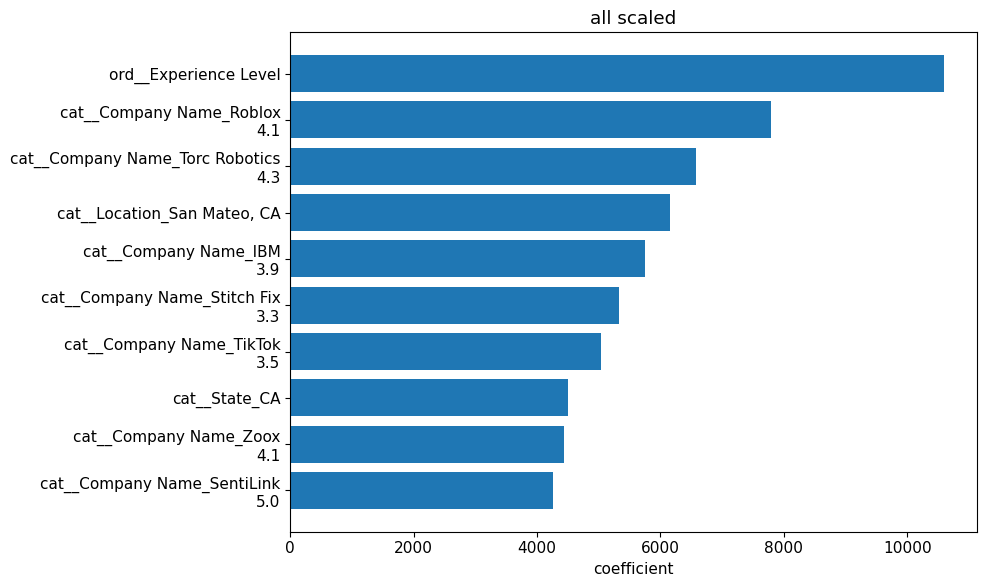

   RMSE: 30968.22900232715
final RMSE: 34358.84180867573
final R2: 0.07277807936262104


In [116]:
RMSE, R2, best_svr = reduced_feature(df_train, y_train, df_CV, y_CV, df_test, y_test, svr_model, svr_params)
print('final RMSE:', RMSE)
print('final R2:', R2)

# Baseline scores

In [96]:
# calculate baseline rmse
baseline_rmse = np.sqrt(np.mean((y_test - np.mean(y_train))**2))
print('Baseline model RMSE:', baseline_rmse)
print('Baseline model R2:', r2_score(y_test, [np.mean(y_train)]*len(y_test)))
print('Test baseline RMSE:', np.sqrt(np.mean((y_test - np.mean(y_test))**2)))
print('Test baseline R2:', r2_score(y_test, [np.mean(y_test)]*len(y_test)))

print('Standard deviation of y_test:', np.std(y_test))

Baseline model RMSE: 36392.749106501535
Baseline model R2: -0.04024679239059359
Test baseline RMSE: 35681.793108782505
Test baseline R2: 0.0
Standard deviation of y_test: 35681.793108782505


# Global features importance

In [62]:
print(best_elastic)

[ElasticNet(alpha=10.0, l1_ratio=1.0), ElasticNet(alpha=100.0, l1_ratio=1.0), ElasticNet(alpha=100.0, l1_ratio=1.0)]


In [63]:
model = best_elastic[0]
test_score = model.score(df_test, y_test)
ftr_names = df_train.columns

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

# loop through the features
for i in range(len(ftr_names)):
    # print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = df_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(df_test[ftr_names[i]].values)
        acc_scores.append(model.score(X_test_shuffled,y_test))
    # print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores
    # sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
    sorted_indcs = np.argsort(np.mean(scores,axis=1))[-10:][::-1]

plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(5,3))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

ValueError: Input X contains NaN.
ElasticNet does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values